In [24]:
%matplotlib inline

### TF Inference

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Suppress TensorFlow logging (2)
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
 tf.config.experimental.set_memory_growth(gpu, True)
IMAGE_PATHS = 'test_images/'

In [26]:
PATH_TO_MODEL = "faster_rcnn_resnet101_v1_640x640_coco17_tpu-8"

In [27]:
PATH_TO_MODEL_DIR = './training/TF2/training/{}/saved_model/saved_model/'.format(PATH_TO_MODEL)

In [28]:
print(PATH_TO_MODEL_DIR)

./training/TF2/training/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/saved_model/


In [29]:
PATH_TO_LABELS = './data/label_map.pbtxt'

In [30]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR
print('Loading model...', end='')
start_time = time.time()
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 7.070664882659912 seconds


In [31]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

Running inference for test_images/picapica219.jpg... Done
Running inference for test_images/periparusater426.jpg... Done
Running inference for test_images/picapica220.jpg... Done
Running inference for test_images/periparusater439.jpg... Done
Running inference for test_images/periparusater435.jpg... Done
Running inference for test_images/ErithacusRubecula0073.jpg... Done
Running inference for test_images/picapica221.jpg... Done
Running inference for test_images/ErithacusRubecula0072.jpg... Done
Running inference for test_images/ErithacusRubecula0074.jpg... Done
Running inference for test_images/picapica44.jpg... Done
Running inference for test_images/periparusater44.jpg... Done
Running inference for test_images/periparusater437.jpg... Done
Running inference for test_images/ErithacusRubecula0062.jpg... Done
Running inference for test_images/picapica216.jpg... Done


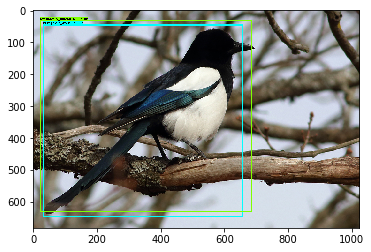

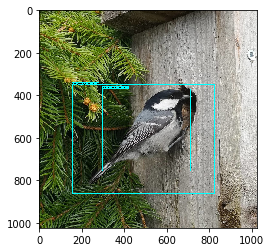

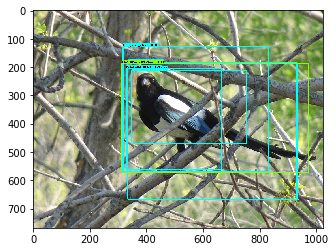

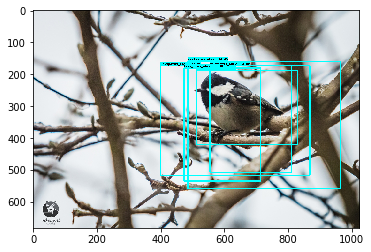

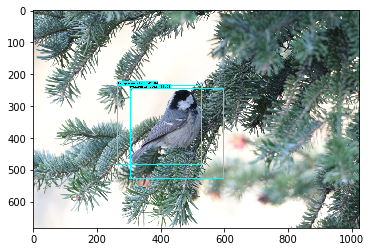

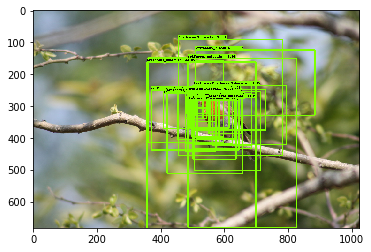

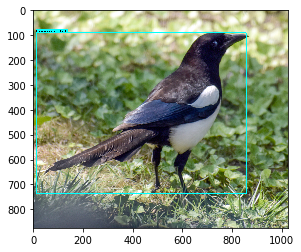

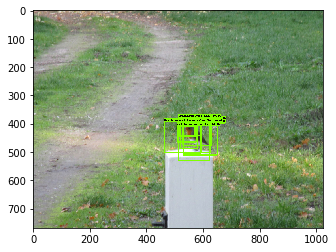

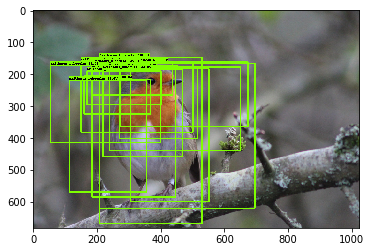

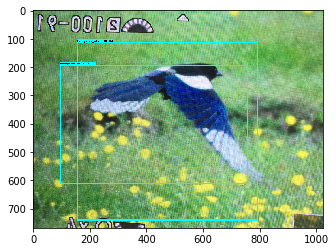

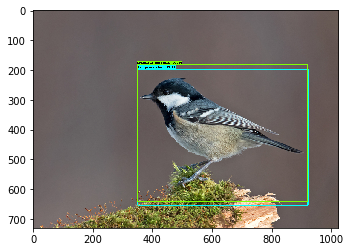

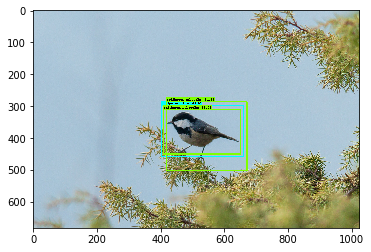

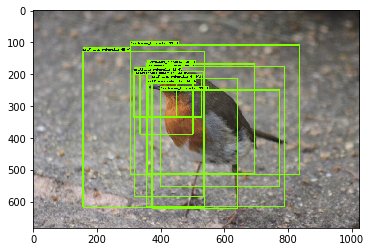

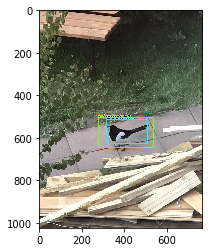

In [42]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore') # Suppress Matplotlib warnings
def load_image_into_numpy_array(path):
 """Load an image from file into a numpy array.
 Puts image into numpy array to feed into tensorflow graph.
 Note that by convention we put it into a numpy array with shape
 (height, width, channels), where channels=3 for RGB.
 Args:
 path: the file path to the image
 Returns:
 uint8 numpy array with shape (img_height, img_width, 3)"""
 return np.array(Image.open(path))
for image_path in os.listdir(IMAGE_PATHS):
 image_path = os.path.join(IMAGE_PATHS, image_path)

 print('Running inference for {}... '.format(image_path), end='')
 image_np = load_image_into_numpy_array(image_path)
 # Things to try:
 # Flip horizontally
 image_np = np.fliplr(image_np).copy()
 # Convert image to grayscale
 # image_np = np.tile(
 #np.mean(image_np, 2, keepdims=True), (1, 1, 3).astype(np.uint8)
 # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
 input_tensor = tf.convert_to_tensor(image_np)
 # The model expects a batch of images, so add an axis with `tf.newaxis`.
 input_tensor = input_tensor[tf.newaxis, ...]
 # input_tensor = np.expand_dims(image_np, 0)
 detections = detect_fn(input_tensor)
 # All outputs are batches tensors.
 # Convert to numpy arrays, and take index [0] to remove the batch dimension.
 # We're only interested in the first num_detections.
 num_detections = int(detections.pop('num_detections'))
 detections = {key: value[0, :num_detections].numpy()
 for key, value in detections.items()}
 detections['num_detections'] = num_detections
 # detection_classes should be ints.
 detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
 image_np_with_detections = image_np.copy()
 viz_utils.visualize_boxes_and_labels_on_image_array(
 image_np_with_detections,
 detections['detection_boxes'],
 detections['detection_classes'],
 detections['detection_scores'],
 category_index,
 use_normalized_coordinates=True,
 max_boxes_to_draw=200,
 min_score_thresh=.30,
 agnostic_mode=False)
 plt.figure()
 plt.imshow(image_np_with_detections)
 print('Done')
plt.show()
# sphinx_gallery_thumbnail_number = 2